# Market selection by using portfolio theory

In [1]:

import os,sys,matplotlib,pandas,numpy,scipy,dateutil
import pandas as pd
import numpy as np
from pylab import *
from datetime import datetime, timedelta
import time
from statsmodels.distributions.empirical_distribution import ECDF
import sqlite3
import itertools, random
import pickle
conn = None


## Reading price data.
Connect to database first, and the slurp the data for the given markets 

In [2]:
markets = [ {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'}
                     ]

In [14]:
str(instance_string(markets[0]))

'us-east-1a-Linux-g2.2xlarge'

In [3]:
def init_db_connection() :
    global conn
    conn = sqlite3.connect('/home/prateeks/spot_prices_2015/aws.db')
    return 

init_db_connection();


In [4]:
print conn

In [5]:
def instance_to_MarketId(i) :
    """ The database table names or the file names  """
    osname = {'Linux':'Linux/UNIX'}
    return i['region']+i['AZ']+'-'+osname[i['OS']]+'-'+i['type']


In [13]:
def instance_string(i):
    return i['region']+i['AZ']+'-'+ i['OS']+'-'+i['type']

In [36]:
def read_data_sqlite(instance , mktstring=None, months=['201503','201504','201505','201506','201507','201508'],pickle_data=True):
    global conn
    table_name_base='AKIAJXNAQH5WHJFPNCXA_' # '201503'
    if mktstring == None:
        mktstring = instance_to_MarketId(instance)
    output=[]
    ondem=[]
    ondemtable = 'on_demand_price'
    #Need to remove avail zone from mkt string argh!
   #TODO: function for converting to the on-demand string 
    ondem_mktstring = mktstring.replace('a-','-')
    ondem_mktstring = ondem_mktstring.replace('/UNIX','')
    q2 = 'SELECT SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(ondemtable, ondem_mktstring)
    d2 = conn.execute(q2)
    ondem = d2.fetchall()

    for month in months :
        table_name = table_name_base+month
        query='SELECT Timestamp, SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(table_name, mktstring)
        #print query
        d = conn.execute(query)
        output.extend(d.fetchall())
    if pickle_data is True :
        fname = instance_string(instance)+'.pickle'
        with open(fname, 'w') as f :
            pickle.dump((instance, output, ondem[0][0]), f)
    return output, ondem[0][0]


In [52]:
def get_spot_data(markets, from_pickle=False):
    """
    markets is a list of dictionaries. Return [(mkt,on-demprice,[(t,spot-price)])]
    """
    global conn
    data = []
    
    if from_pickle is False:
        init_db_connection()
        #c3.xlarge seems volatile
        for i in markets :
            ts, ondem = read_data_sqlite(i)
            spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
            nspot = np.array(spot)
            data.append((i, float(ondem), nspot))
    else : 
        #Read all the pickle files from the directory and call get_pickled_data
        for file in os.listdir('.'):
            if file.endswith(".pickle") :
                with open(file,'r') as f:
                    (i, ts, ondem) = get_picked_data(f)
                    spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
                    nspot = np.array(spot)
                    data.append((i, float(ondem), nspot))

    return data


In [53]:
def get_picked_data(f):
    """ Get pickled data from a file. Return (instance, ts, ondem) tuple. """
    (instance, ts, ondem) = pickle.load(f)
    return (instance, ts, ondem)
    

In [54]:
ls

all-cdf.py               time_series_1.ipynb
Bidding_1.ipynb          Untitled0-Copy0_1.ipynb
Bidding_2.ipynb          Untitled0.ipynb
Correlation-Copy0.ipynb  Untitled1.ipynb
Correlation.ipynb        Untitled2.ipynb
ft-mechanisms.py         us-east-1a-Linux-c3.xlarge.pickle
overyears.py             us-east-1a-Linux-d2.8xlarge.pickle
parr_ex_price.py         us-east-1a-Linux-g2.2xlarge.pickle
README.md                us-east-1a-Linux-m3.medium.pickle
spike_correlation.ipynb  us-east-1a-Linux-r3.large.pickle
spot_analysis.py         var-risk-Copy1.ipynb
spotfail.py*             var-risk.ipynb
testr.R                  years.ipynb


In [55]:
data = get_spot_data(markets, from_pickle=True)

In [56]:
def get_prices_only(d, normalized=False):
    """ For a given 3-tuple, return an array of prices. Strip the timestamps
    """
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    
    if normalized:
        return spot_prices/ondem_price  #time, price
    else :
        return spot_prices
    
#normalized_price(data[0])

In [75]:
a=np.array([1,2,3,1,5,3,2,1])
a[a>=3]=100
print a[:2]
print len(a)

[1 2]
8


In [161]:
def bid_transform(d):
    """Given a bid, execute some transformation over the prices."""
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    maxprice = 10*ondem_price
    bid = ondem_price 
    spot_prices[spot_prices >= bid] = maxprice #Amplify the price spike
    spot_prices = (10*ondem_price) - spot_prices  #Price => Profits transformation
    #Not sure we want to normalize this to the on-demand price? Hmm...
    #Normalizing by 10*on-demand price yields returns which are monotonically *DECREASING* with risk
    #We want increasing returns with increasing risk, so turn off the normalization
    return spot_prices
    


In [162]:
prices = get_prices_only(data[0])
scipy.stats.describe(prices)

DescribeResult(nobs=23459, minmax=(0.064100000000000004, 6.5), mean=0.26929619591627946, variance=1.079290056470753, skewness=5.816131066067971, kurtosis=31.91528783941245)

In [163]:
def get_transformed_prices(d):
    td = [] #List of transformed prices
    instances = []
    for di in d:
        td.append(bid_transform(di))
        instances.append(di[0])
    min_length = min([len(a) for a in td])

    print min_length
    return (instances, np.vstack([a[:min_length] for a in td]) )


In [164]:
(instances, dt) = get_transformed_prices(data)

3755


In [165]:
np.shape(dt)
np.cov(dt)

array([[  9.91135311e-02,  -5.62824899e-04,  -1.23815047e-03,
         -5.52116991e-02,  -8.79229878e-04],
       [ -5.62824899e-04,   6.39331292e-02,  -1.94758731e-03,
          5.06789920e-01,  -1.60978451e-03],
       [ -1.23815047e-03,  -1.94758731e-03,   1.15786561e-01,
         -1.35159941e-01,   4.84461610e-03],
       [ -5.52116991e-02,   5.06789920e-01,  -1.35159941e-01,
          1.50678266e+02,  -4.77425854e-02],
       [ -8.79229878e-04,  -1.60978451e-03,   4.84461610e-03,
         -4.77425854e-02,   2.79078751e-02]])

## Portfolio construction starts here
So far we have read in the spot prices, applied the transforms, and computed the covariance matrix. Now its time for the actual portfolio creation.


In [203]:
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [204]:
solvers.options['show_progress'] = False

In [205]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [206]:
num_mkts = len(instances)

In [207]:
print num_mkts

5


In [208]:
print rand_weights(num_mkts)

[ 0.12345509  0.1079809   0.35119969  0.10519123  0.31217308]


In [209]:
np.mean(dt, axis=1)

array([  6.41758503,   2.03584431,   1.661829  ,  51.29888479,   0.60888451])

In [210]:
np.asmatrix(np.mean(dt,axis=1))

matrix([[  6.41758503,   2.03584431,   1.661829  ,  51.29888479,
           0.60888451]])

In [211]:
np.asmatrix(rand_weights(dt.shape[0]))

matrix([[ 0.22525793,  0.14621614,  0.31335411,  0.12196954,  0.19320227]])

In [212]:
def eval_portfolio(dt):
    p = np.asmatrix(np.mean(dt,axis=1))
    w = np.asmatrix(rand_weights(dt.shape[0]))
    C = np.asmatrix(np.cov(dt))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    print mu, sigma
    
    return mu, sigma

In [213]:
n_portfolios = 100
means, stds = np.column_stack([
    eval_portfolio(dt) 
    for _ in xrange(n_portfolios)
])


[[ 21.72830478]] [[ 4.59693269]]
[[ 24.31745479]] [[ 5.47066565]]
[[ 9.24840375]] [[ 1.8369901]]
[[ 13.92807651]] [[ 2.97943766]]
[[ 12.73377662]] [[ 2.4562937]]
[[ 13.77764004]] [[ 2.67788779]]
[[ 6.24926036]] [[ 1.16042225]]
[[ 13.191669]] [[ 2.57352649]]
[[ 8.55499797]] [[ 1.6115637]]
[[ 6.69538733]] [[ 0.99160443]]
[[ 17.58966597]] [[ 3.54584844]]
[[ 22.89437978]] [[ 4.96654672]]
[[ 11.87565942]] [[ 2.54474954]]
[[ 8.26130647]] [[ 1.41649095]]
[[ 4.88949539]] [[ 0.66006612]]
[[ 11.05364964]] [[ 2.37368754]]
[[ 15.89306078]] [[ 3.2490757]]
[[ 11.99996307]] [[ 2.27500562]]
[[ 12.17635401]] [[ 2.25182206]]
[[ 19.17794908]] [[ 4.08386645]]
[[ 10.61073049]] [[ 2.25479711]]
[[ 10.01810475]] [[ 1.92494245]]
[[ 12.50311015]] [[ 2.28361518]]
[[ 5.63267064]] [[ 1.01447944]]
[[ 10.97641087]] [[ 2.07583916]]
[[ 16.99453017]] [[ 3.46004233]]
[[ 10.55110973]] [[ 2.02607868]]
[[ 5.96163468]] [[ 0.8668357]]
[[ 11.19591369]] [[ 1.99345394]]
[[ 18.29379132]] [[ 3.9146527]]
[[ 14.51219767]] [[ 2.8555

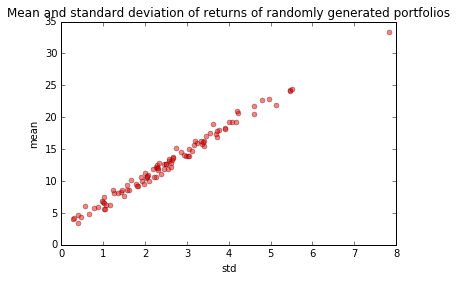

In [214]:
plt.plot(stds, means, 'o', markersize=5, color='r', alpha=0.5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


In [221]:
def optimal_portfolio(returns, pbar):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    
    #pbar = opt.matrix(np.mean(returns, axis=1))
     
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [222]:
p = opt.matrix(np.mean(dt, axis=1))
print p.size
optimal_portfolio(dt,  opt.matrix(np.mean(dt, axis=1)))

(5, 1)


ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [217]:
weights, returns, risks = optimal_portfolio(dt)

TypeError: error converting array

In [186]:
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

TypeError: error converting array

In [12]:
def my_covariance(x,y):
    """
    This yields similiar results to
    pd.Series(x).cov(pd.Series(y)) """
    xbar = x.mean()
    ybar = y.mean()
    x = x-xbar
    y = y-ybar
    n = min(x.shape[0], y.shape[0])
    x = x[:n-1]
    y = y[:n-1]
    cov = (x*y)
    cov = np.sum(cov)/(n-1)
    print cov
    return cov


In [114]:
print dt

[[ -6.4348  -6.435   -6.4349 ...,  -6.4347  -6.4351  -6.4354]
 [ -2.0676  -2.0679  -2.0676 ...,  -2.0679  -2.0654  -2.0679]
 [ -1.7281   0.      -1.733  ...,  -1.7318  -1.7313  -1.7331]
 [-54.64   -54.6365 -54.6361 ..., -54.6354 -54.6348 -54.6354]
 [  0.       0.       0.     ...,  -0.653   -0.653   -0.653 ]]


In [13]:
my_covariance(x,y)

-8.02333628098e-05


-8.0233362809846391e-05

In [14]:
pd.Series(x).cov(pd.Series(y))

-8.0003161504696132e-05

In [16]:

d0=data[0]
d1=data[1]
print d0

({'OS': 'Linux', 'region': 'us-east-1', 'AZ': 'a', 'type': 'g2.2xlarge'}, 0.65, array([[  1.42611080e+09,   6.52000000e-02],
       [  1.42611117e+09,   6.50000000e-02],
       [  1.42611153e+09,   6.51000000e-02],
       ..., 
       [  1.44108320e+09,   1.25300000e-01],
       [  1.44108337e+09,   1.18500000e-01],
       [  1.44108353e+09,   1.14200000e-01]]))


In [17]:
s0 = pd.Series(d0[2][:,1], index=d0[2][:,0])